In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tracemalloc
import time
import tqdm
import os
import csv

In [2]:
import branch_and_bound
import twice_around_the_tree
import christofides
import utils

In [3]:
datasets = pd.read_table('./data/tp2_datasets.txt')
datasets.head()

,Dataset,Nós,Limiar
0,eil51,51,426
1,berlin52,52,7542
2,st70,70,675
3,eil76,76,538
4,pr76,76,108159


### Algoritmos aproximativos

In [ ]:
columns = ['Dataset', 'Nodes', 'Optimal', 'Algorithm', 'Cost', 'Error', 'Elapsed time', 'Memory usage']

file_path = './results/aproximative_algorithms_results.csv'

with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(columns)

for row in datasets.iterrows():

    dataset = row[1].Dataset
    nodes = int(row[1].Nós)
    optimal_cost = int(row[1].Limiar)

    matrix = utils.get_dataset_matrix(dataset)

    # Using twice around the tree
    jump_tat = False

    if not jump_tat:
        tracemalloc.start()
        current, peak = tracemalloc.get_traced_memory()

        start_time = time.time()
        path, cost = twice_around_the_tree.twice_around_the_tree(matrix)
        tat_elapsed_time = time.time() - start_time

        current_after, peak_after = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        # Converte a memória usada para MB
        tat_max_memory = (peak_after - peak) / (1024 ** 2)

        with open(file_path, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([dataset, nodes, optimal_cost, 'tat', int(cost), cost / optimal_cost - 1, tat_elapsed_time, tat_max_memory])

        if tat_elapsed_time / 60 > 30:
            jump_tat = True 
    
    # Using Christofides
    jump_chr = False

    if not jump_chr:
        tracemalloc.start()
        current, peak = tracemalloc.get_traced_memory()

        start_time = time.time()
        path, cost = christofides.christofides(matrix)
        chr_elapsed_time = time.time() - start_time

        current_after, peak_after = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        # Converte a memória usada para MB
        chr_max_memory = (peak_after - peak) / (1024 ** 2)

        with open(file_path, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([dataset, nodes, optimal_cost, 'chr', int(cost), cost / optimal_cost - 1, chr_elapsed_time, chr_max_memory])

        if chr_elapsed_time / 60 > 30:
            jump_chr = True

### Branch and Bound

#### Testando priorização

In [6]:
columns = ['Nodes', 'Priority method', 'Cost', 'Leaves count', 'Elapsed time', 'Finished']

file_path = './results/priority_method_results.csv'

with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(columns)

np.random.seed(1)

for i in range(100):

    matrix = np.random.randint(1, 50, size=(20, 20))
    matrix = (matrix + matrix.T) // 2
    np.fill_diagonal(matrix, 0)

    # Using regular priority
    start_time = time.time()
    path, best, finished, leaves_count = branch_and_bound.tsp(matrix, priority='regular', time_limit=1)
    reg_elapsed_time = time.time() - start_time

    with open(file_path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([20, 'reg', best, leaves_count, reg_elapsed_time, finished])
    
    # Using optimized priority
    start_time = time.time()
    path, best, finished, leaves_count = branch_and_bound.tsp(matrix, priority='optimized', time_limit=1)
    opt_elapsed_time = time.time() - start_time

    with open(file_path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([20, 'opt', best, leaves_count, opt_elapsed_time, finished])

#### Aplicando o BnB nas instâncias

In [11]:
columns = ['Dataset', 'Nodes', 'Optimal', 'Finished', 'Leaves count', 'Best', 'Error', 'Elapsed time', 'Memory usage']

file_path = './results/branch_and_bound_results1.csv'

with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(columns)

for row in datasets.iterrows():

    dataset = row[1].Dataset
    nodes = int(row[1].Nós)
    optimal_cost = int(row[1].Limiar)

    matrix = utils.get_dataset_matrix(dataset)

    tracemalloc.start()
    current, peak = tracemalloc.get_traced_memory()

    start_time = time.time()
    path, best, finished, leaves_count = branch_and_bound.tsp(matrix, priority='optimized')
    elapsed_time = time.time() - start_time

    current_after, peak_after = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Converte a memória usada para MB
    max_memory = (peak_after - peak) / (1024 ** 2)

    with open(file_path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([dataset, nodes, optimal_cost, finished, leaves_count, int(best), best / optimal_cost - 1, elapsed_time, max_memory])

### Resultados

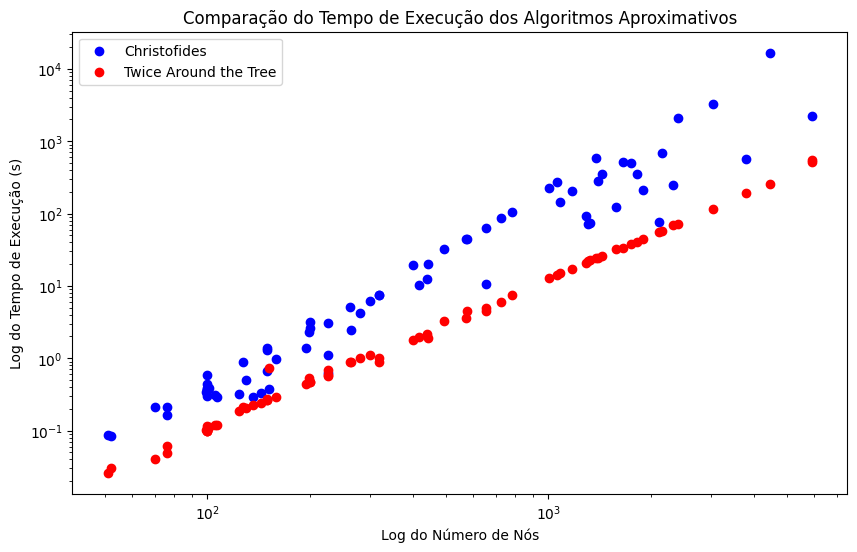

In [11]:
df = pd.read_csv('./results/aproximative_algorithms_results.csv')

df_chr = df[df['Algorithm'] == 'chr']
df_tat = df[df['Algorithm'] == 'tat']

plt.figure(figsize=(10, 6))
plt.scatter(df_chr['Nodes'], df_chr['Elapsed time'], color='blue', label='Christofides')
plt.scatter(df_tat['Nodes'], df_tat['Elapsed time'], color='red', label='Twice Around the Tree')

plt.xscale('log')
plt.yscale('log')

plt.title('Comparação do Tempo de Execução dos Algoritmos Aproximativos')
plt.xlabel('Log do Número de Nós')
plt.ylabel('Log do Tempo de Execução (s)')
plt.legend()

plt.show()


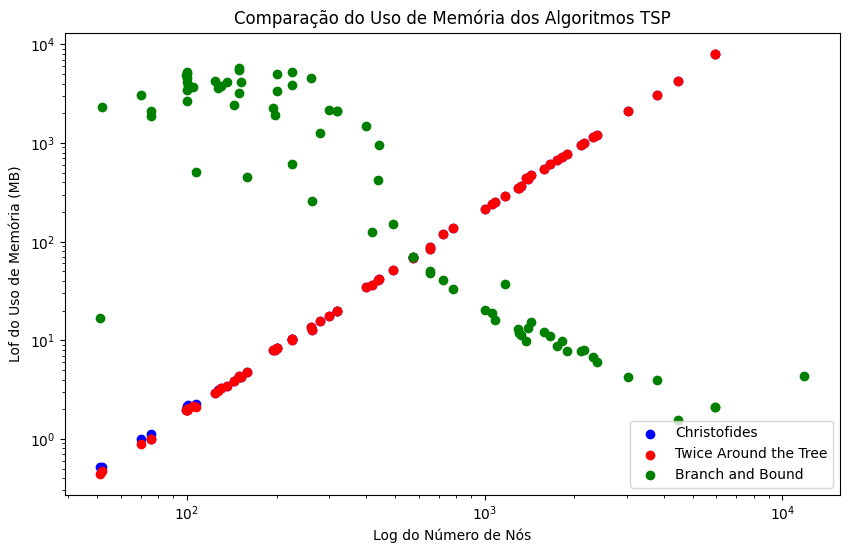

In [13]:
df_approx = pd.read_csv('./results/aproximative_algorithms_results.csv')
df_bb = pd.read_csv('./results/branch_and_bound_results.csv')

df_bb['Algorithm'] = 'bb'

df_combined = pd.concat([df_approx, df_bb])

df_chr = df_combined[df_combined['Algorithm'] == 'chr']
df_tat = df_combined[df_combined['Algorithm'] == 'tat']
df_bb = df_combined[df_combined['Algorithm'] == 'bb']

plt.figure(figsize=(10, 6))
plt.scatter(df_chr['Nodes'], df_chr['Memory usage'], color='blue', label='Christofides')
plt.scatter(df_tat['Nodes'], df_tat['Memory usage'], color='red', label='Twice Around the Tree')
plt.scatter(df_bb['Nodes'], df_bb['Memory usage'], color='green', label='Branch and Bound')

plt.xscale('log')
plt.yscale('log')

plt.title('Comparação do Uso de Memória dos Algoritmos TSP')
plt.xlabel('Log do Número de Nós')
plt.ylabel('Lof do Uso de Memória (MB)')
plt.legend()

plt.show()

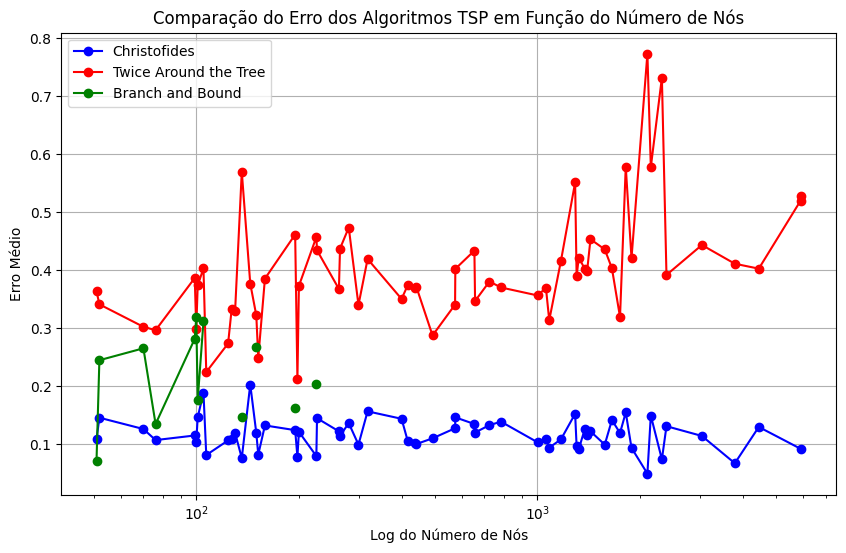

In [19]:
df_approx = pd.read_csv('./results/aproximative_algorithms_results.csv')
df_bb = pd.read_csv('./results/branch_and_bound_results.csv')

df_bb['Algorithm'] = 'bb'

df_combined = pd.concat([df_approx, df_bb])

df_grouped = df_combined.groupby(['Nodes', 'Algorithm'])['Error'].mean().reset_index()

df_chr = df_grouped[df_grouped['Algorithm'] == 'chr']
df_tat = df_grouped[df_grouped['Algorithm'] == 'tat']
df_bb = df_grouped[df_grouped['Algorithm'] == 'bb']

plt.figure(figsize=(10, 6))
plt.plot(df_chr['Nodes'], df_chr['Error'], '-o', color='blue', label='Christofides')
plt.plot(df_tat['Nodes'], df_tat['Error'], '-o', color='red', label='Twice Around the Tree')
plt.plot(df_bb['Nodes'], df_bb['Error'], '-o', color='green', label='Branch and Bound')

plt.title('Comparação do Erro dos Algoritmos TSP em Função do Número de Nós')
plt.xlabel('Log do Número de Nós')
plt.ylabel('Erro Médio')
plt.legend()
plt.grid(True)

plt.xscale('log')

plt.show()

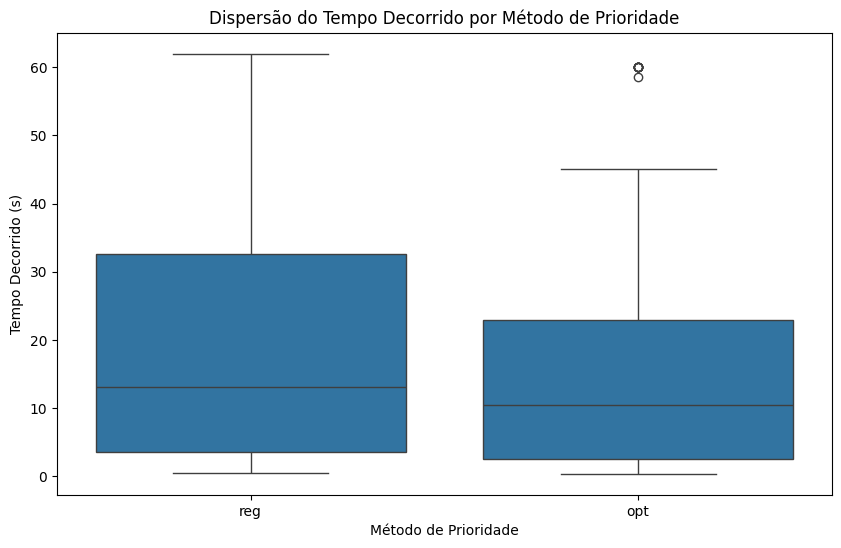

In [21]:
df = pd.read_csv('./results/priority_method_results.csv')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Priority method', y='Elapsed time', data=df)

plt.title('Dispersão do Tempo Decorrido por Método de Prioridade')
plt.xlabel('Método de Prioridade')
plt.ylabel('Tempo Decorrido (s)')

plt.show()


In [22]:
df = pd.read_csv('./results/priority_method_results.csv')

media_reg = df[df['Priority method'] == 'reg']['Leaves count'].mean()
media_opt = df[df['Priority method'] == 'opt']['Leaves count'].mean()

print(f'Regular: {media_reg}')
print(f'Optimized: {media_opt}')

Regular: 0.898989898989899
Optimized: 6.0
